In [61]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [62]:
# ========== CONFIGURACIÓN Y CARGA DE DATOS ==========
SEQ_LENGTH = 30
MODEL_DIR = "modelos_lstm_tuned"
CSV_PATH = "SP500_HMM_States.csv"
SHOW_PLOTS = True

# Cargar dataset
df = pd.read_csv(CSV_PATH)
df['Date'] = pd.to_datetime(df['Date'])

# Validación de columnas
assert 'Return' in df.columns and 'State' in df.columns, "Faltan columnas necesarias"

# Escalar retornos
scaler = StandardScaler()
df['Return_scaled'] = scaler.fit_transform(df[['Return']])
scaled_data = df['Return_scaled'].values.reshape(-1, 1)

print("Media:", np.mean(df['Return_scaled']))
print("Desviación estándar:", np.std(df['Return_scaled']))


Media: -2.260715035825963e-18
Desviación estándar: 1.0000000000000007


In [63]:
# ========== FUNCIONES AUXILIARES ==========
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return mse, mae, rmse, r2, acc

def predecir_modelo(model, data, scaler):
    gen = TimeseriesGenerator(data, data, length=SEQ_LENGTH, batch_size=1)
    y_true_scaled = data[SEQ_LENGTH:]
    y_pred_scaled = model.predict(gen)
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    return y_true, y_pred


In [64]:
# ========== EVALUAR MODELOS GENERAL Y POR ESTADO ==========
resultados = []
model_outputs = []

# 🧠 Modelo general
modelo_general_path = os.path.join(MODEL_DIR, "LSTM_Full_Series.h5")
if os.path.exists(modelo_general_path):
    model = load_model(modelo_general_path, compile=False)
    y_true, y_pred = predecir_modelo(model, scaled_data, scaler)
    fechas = df['Date'].values[SEQ_LENGTH:]
    mse, mae, rmse, r2, acc = calcular_metricas(y_true, y_pred)

    resultados.append({
        'Modelo': 'General',
        'State': 'Todos',
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Accuracy_Dir': acc
    })

    model_outputs.append({
        'Label': "Modelo General",
        'Fechas': fechas,
        'y_true': y_true,
        'y_pred': y_pred
    })
else:
    print("⚠️ Modelo general no encontrado.")

# 🧠 Modelos por estado
for state in sorted(df['State'].unique()):
    model_path = os.path.join(MODEL_DIR, f"LSTM_State_{state}.h5")
    df_state = df[df['State'] == state]

    if len(df_state) <= SEQ_LENGTH + 1:
        continue

    data_state = df_state['Return_scaled'].values.reshape(-1, 1)
    fechas_state = df_state['Date'].values[SEQ_LENGTH:]

    if os.path.exists(model_path):
        model = load_model(model_path, compile=False)
        y_true, y_pred = predecir_modelo(model, data_state, scaler)
        mse, mae, rmse, r2, acc = calcular_metricas(y_true, y_pred)

        resultados.append({
            'Modelo': 'Especializado',
            'State': state,
            'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Accuracy_Dir': acc
        })

        model_outputs.append({
            'Label': f"Especializado - Estado {state}",
            'Fechas': fechas_state,
            'y_true': y_true,
            'y_pred': y_pred
        })
    else:
        print(f"Modelo para Estado {state} no encontrado.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6256/6256 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


775/775 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Modelo para Estado 1 no encontrado.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2641/2641 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2331/2331 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step
Modelo para Estado 4 no encontrado.


In [65]:
# ========== MOSTRAR Y EXPORTAR RESULTADOS ==========
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='MAE')

print("📊 Resultados por modelo:")
display(df_resultados)

df_resultados.to_csv("resultados_modelos_lstm.csv", index=False)
print(f"\n📁 Resultados exportados a: resultados_modelos_lstm.csv")

📊 Resultados por modelo:


,Modelo,State,MSE,MAE,RMSE,R2,Accuracy_Dir
2,Especializado,2,0.000022,0.003665,0.004673,-0.009380,0.607346
1,Especializado,0,0.000053,0.005977,0.007302,0.025315,0.716129
0,General,Todos,0.000147,0.008029,0.012128,-0.000362,0.534687
3,Especializado,3,0.000190,0.010722,0.013782,0.018337,0.532819



📁 Resultados exportados a: resultados_modelos_lstm.csv


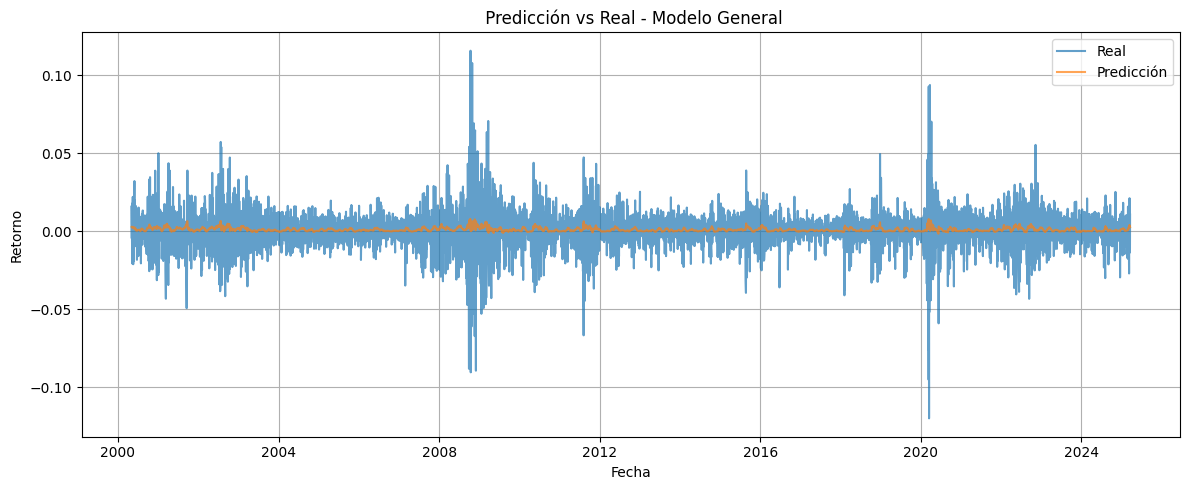

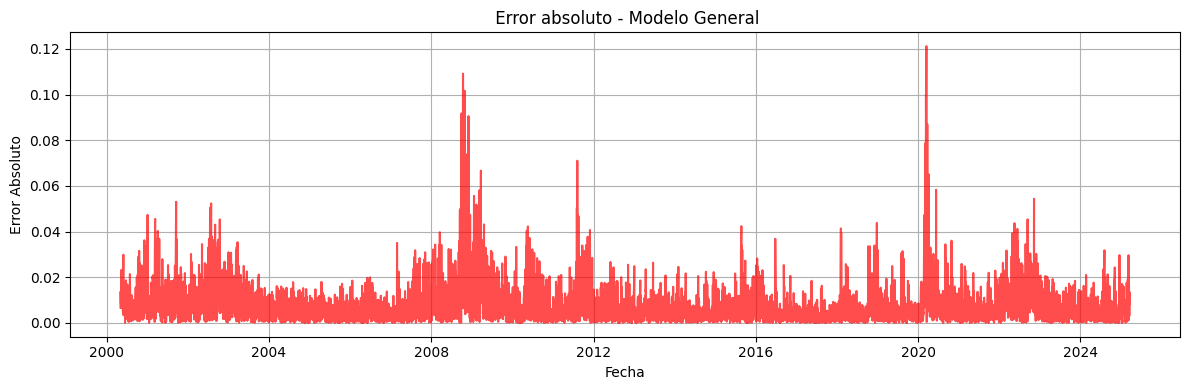

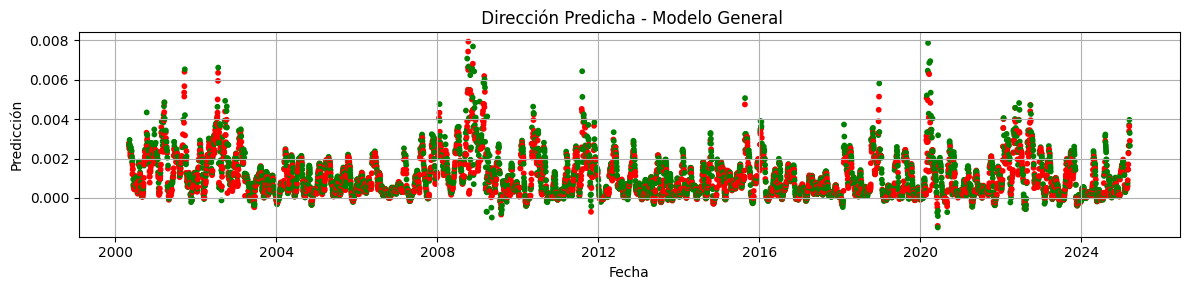

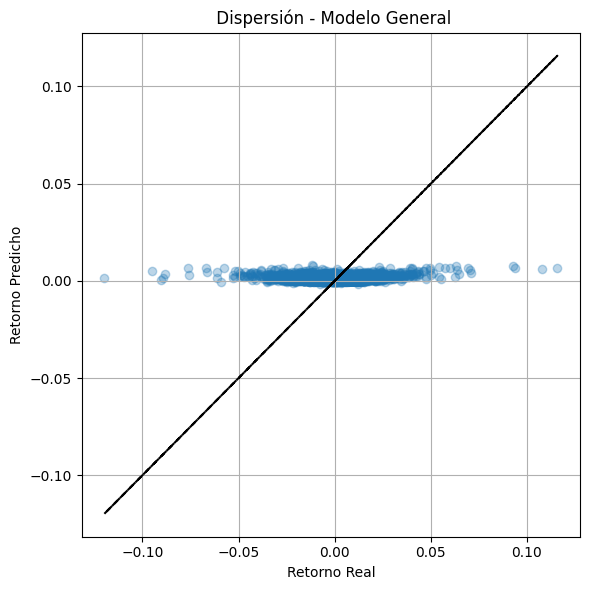

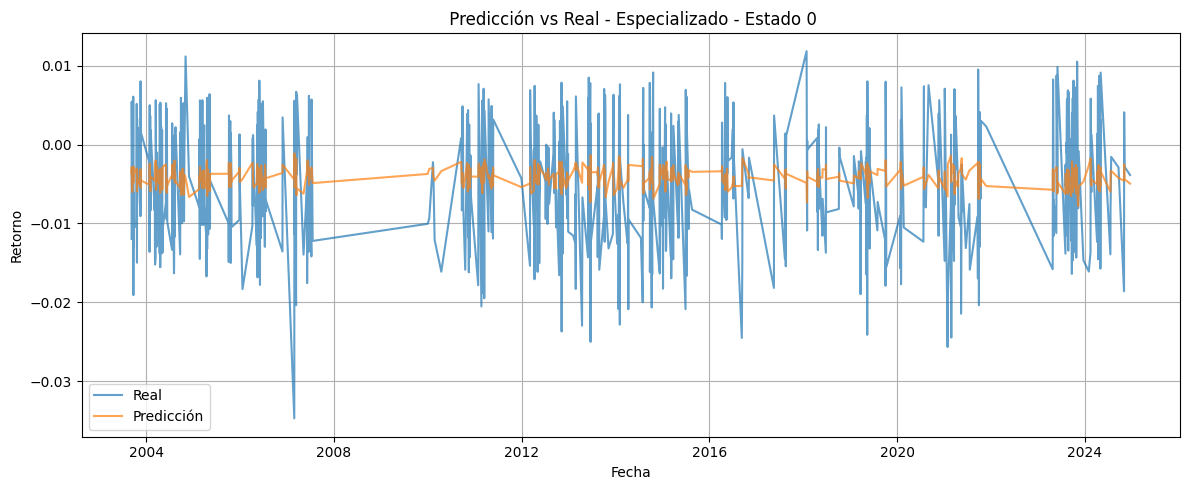

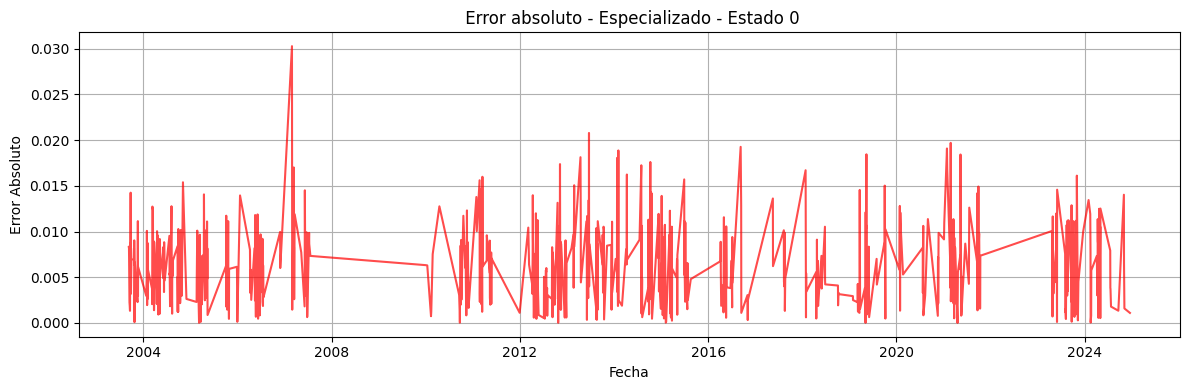

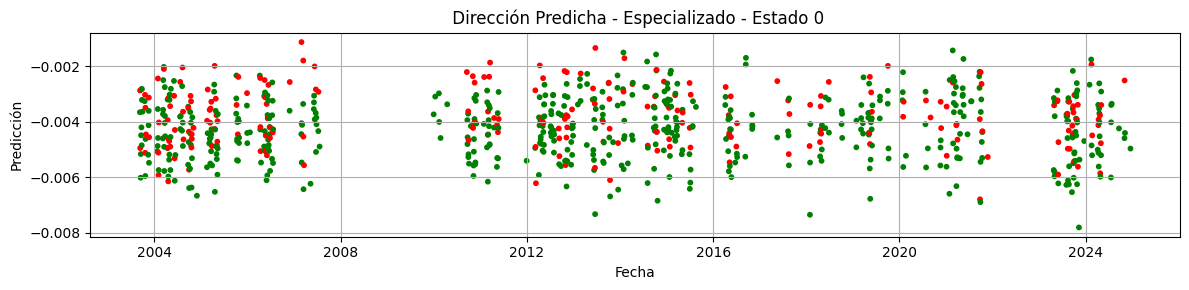

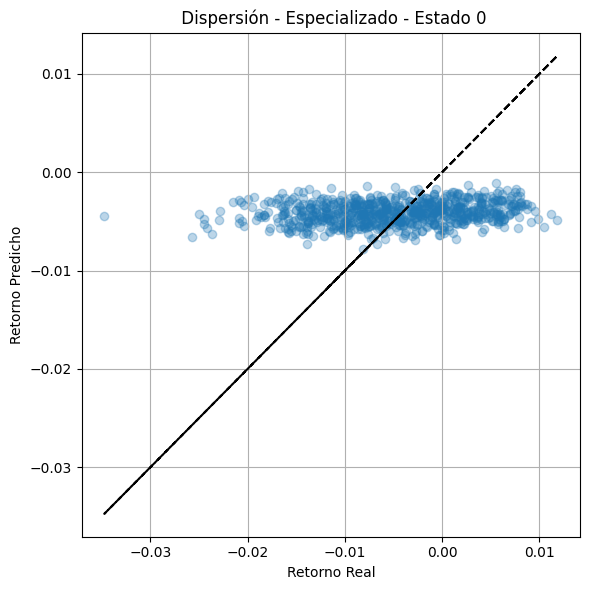

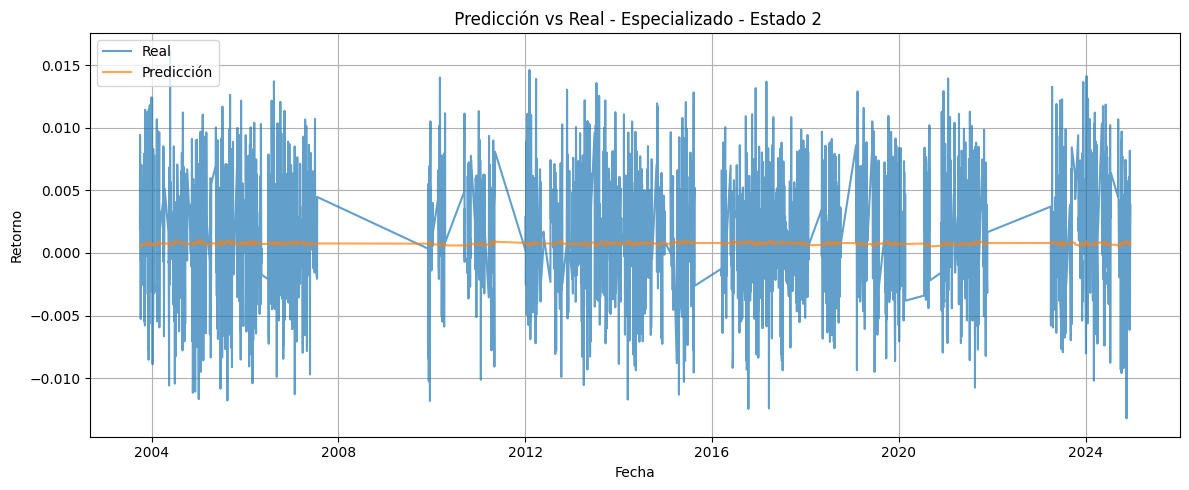

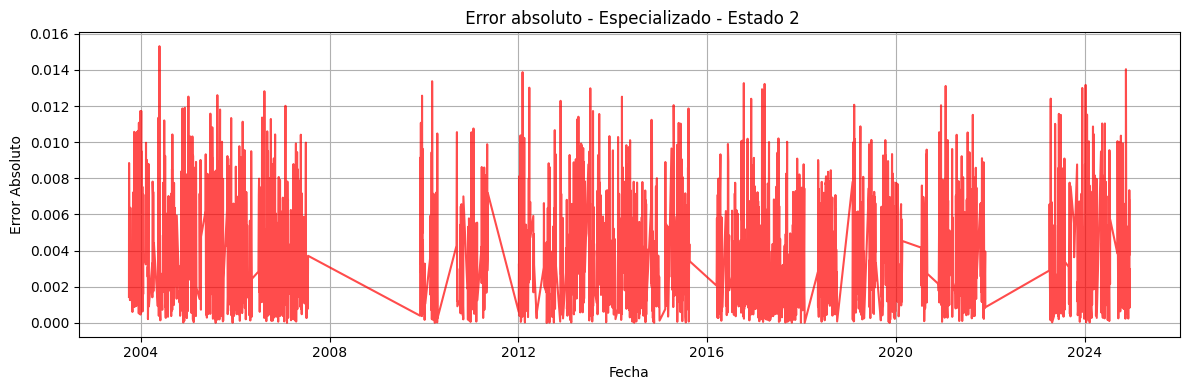

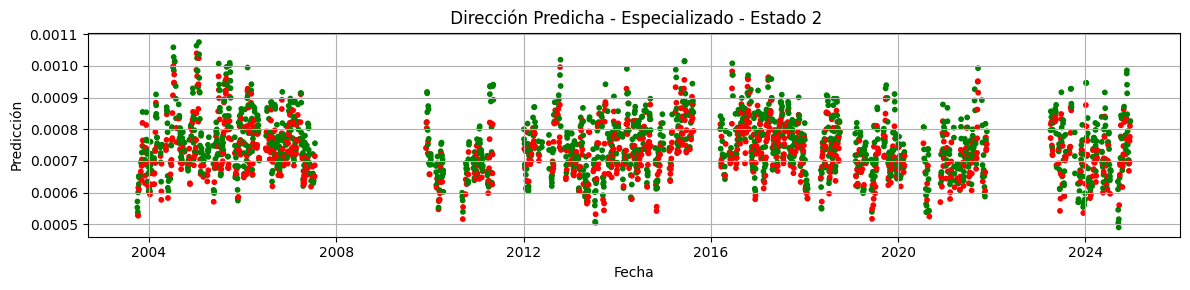

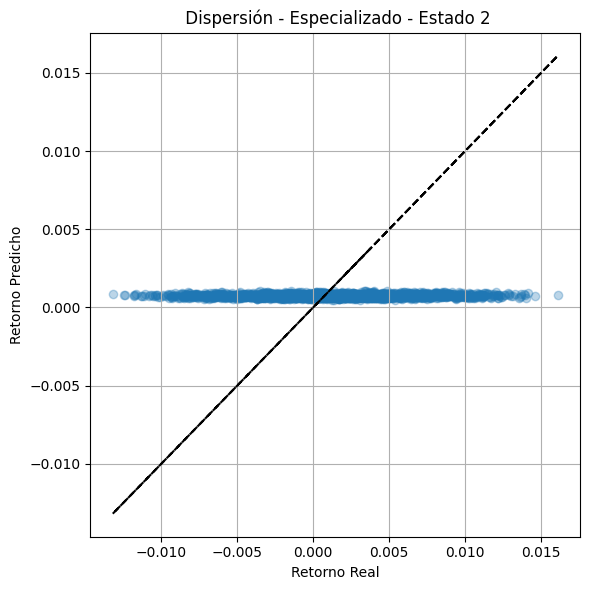

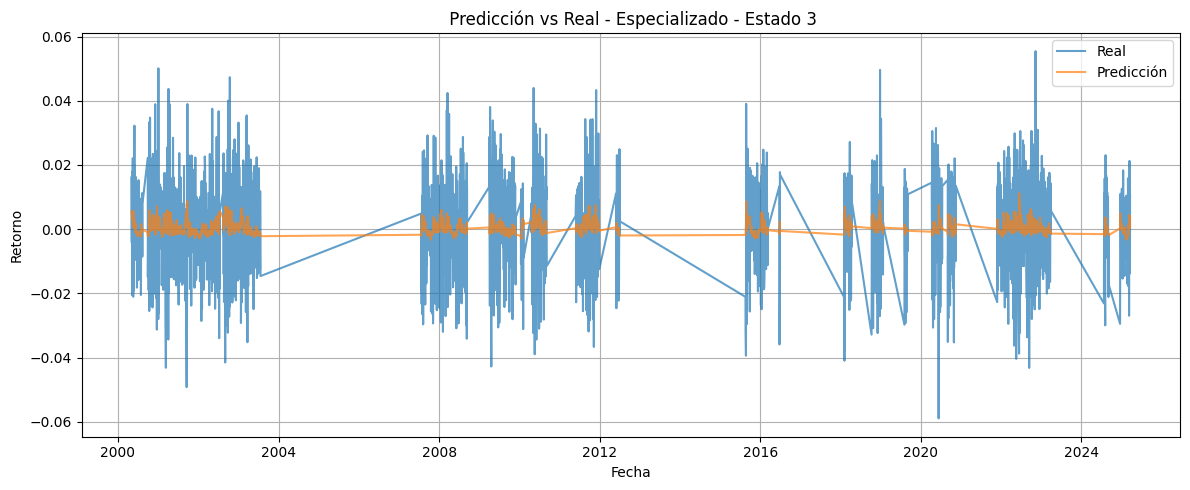

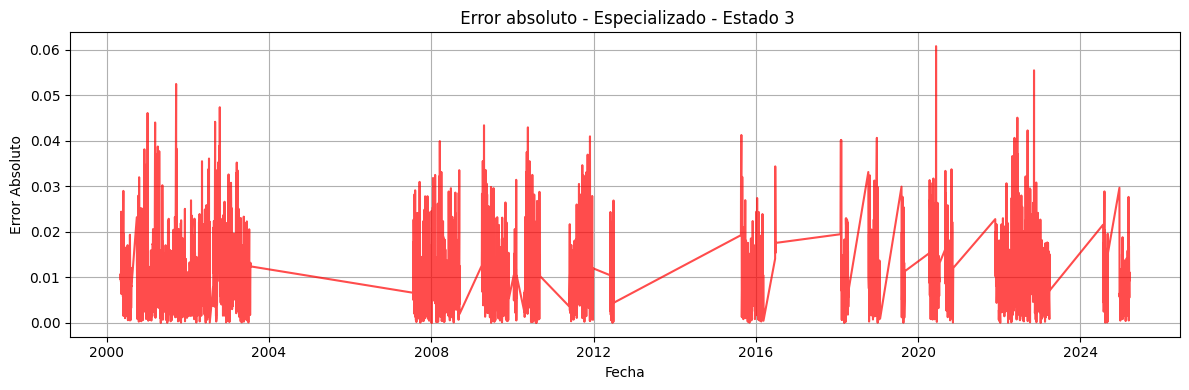

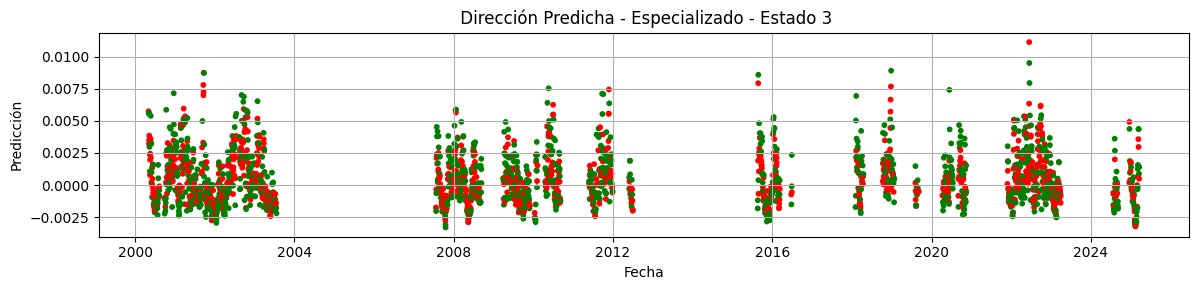

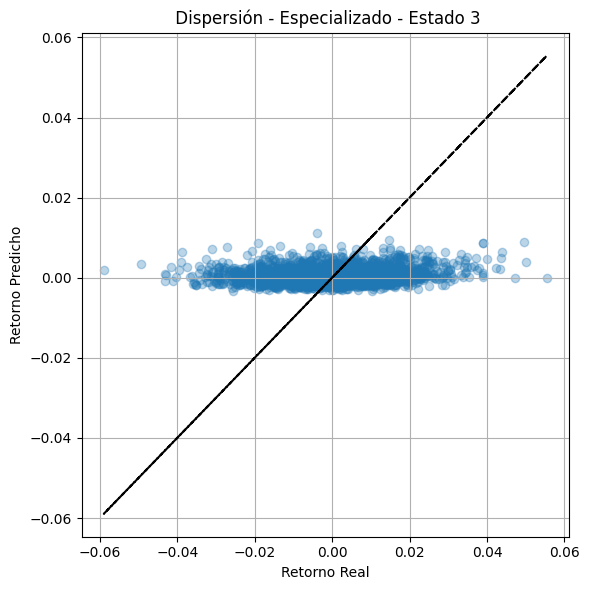

In [66]:
# ========== GRÁFICOS POR MODELO ==========
for salida in model_outputs:
    label = salida['Label']
    fechas = salida['Fechas']
    y_true = salida['y_true']
    y_pred = salida['y_pred']

    error_abs = np.abs(y_true - y_pred)
    aciertos = np.sign(y_true) == np.sign(y_pred)
    colors = ['green' if acierto else 'red' for acierto in aciertos]

    # 0. Predicción vs Real
    plt.figure(figsize=(12, 5))
    plt.plot(fechas, y_true, label="Real", alpha=0.7)
    plt.plot(fechas, y_pred, label="Predicción", alpha=0.7)
    plt.title(f" Predicción vs Real - {label}")
    plt.xlabel("Fecha")
    plt.ylabel("Retorno")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 1. Error absoluto
    plt.figure(figsize=(12, 4))
    plt.plot(fechas, error_abs, color='red', alpha=0.7)
    plt.title(f" Error absoluto - {label}")
    plt.xlabel("Fecha")
    plt.ylabel("Error Absoluto")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Dirección acertada
    plt.figure(figsize=(12, 3))
    plt.scatter(fechas, y_pred, c=colors, s=10)
    plt.title(f" Dirección Predicha - {label}")
    plt.xlabel("Fecha")
    plt.ylabel("Predicción")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # 3. Dispersión
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot(y_true, y_true, color='black', linestyle='--')
    plt.title(f" Dispersión - {label}")
    plt.xlabel("Retorno Real")
    plt.ylabel("Retorno Predicho")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


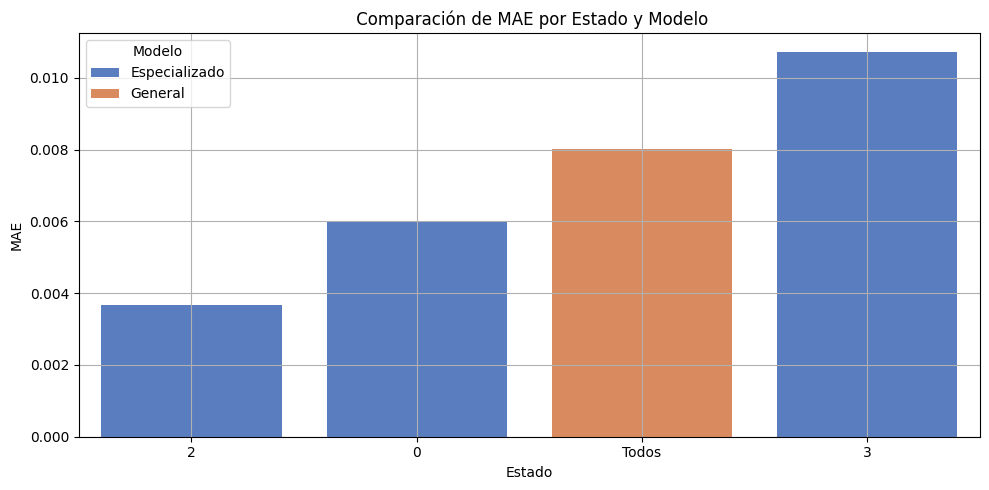

In [67]:
# ========== RANKING FINAL DE MODELOS ==========
plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="State", y="MAE", hue="Modelo", palette="muted")
plt.title(" Comparación de MAE por Estado y Modelo")
plt.ylabel("MAE")
plt.xlabel("Estado")
plt.grid(True)
plt.tight_layout()
plt.show()
